In [1]:
# 9.1 - Evaluating a Bayesian Net on adversarial examples

In [2]:
%load_ext autoreload
%autoreload 2
# Disable jedi autocompleter
%config Completer.use_jedi = False

In [3]:
# custom library imports
import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [4]:
import torch
import numpy as np
from scipy import stats

In [5]:
import matplotlib as mpl
# # set this 'backend' when using jupyter; do this before importing pyplot
# mpl.use('nbagg')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

In [6]:
# check gpus
!gpustat

countdown                      Sat May 21 01:19:35 2022  465.19.01
[0] NVIDIA GeForce RTX 2080 Ti | 79'C,  14 % |  8738 / 11019 MB | enis(7799M) enis(935M)
[1] NVIDIA GeForce RTX 2080 Ti | 87'C,  19 % |  7941 / 11018 MB | enis(7799M) root(137M)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# manually set cuda device
torch.cuda.set_device(0)
device = 'cpu'
print(device)

cpu


In [8]:
import torch.nn.functional as F

In [9]:
# load pretrained Bayesian Net

In [10]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [11]:
# the network itself
hidden_layer_sizes = [64,64]
drop_p = 0.01
net = fgnl.Feedforward_Classic_net(in_feats=28*28, out_feats=10, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p)

In [12]:
# the pyro model
def model(x_data, y_data):
    
    # input batchnorm layer 
    ibw_prior = Normal(loc=torch.zeros_like(net.ib.weight), scale=torch.ones_like(net.ib.weight))
    ibb_prior = Normal(loc=torch.zeros_like(net.ib.bias), scale=torch.ones_like(net.ib.bias))
    
    # first linear layer
    hl1w_prior = Normal(loc=torch.zeros_like(net.hidden_layers[1].weight), scale=torch.ones_like(net.hidden_layers[1].weight))
    hl1b_prior = Normal(loc=torch.zeros_like(net.hidden_layers[1].bias), scale=torch.ones_like(net.hidden_layers[1].bias))
    # first batchnorm
    hl2w_prior = Normal(loc=torch.zeros_like(net.hidden_layers[2].weight), scale=torch.ones_like(net.hidden_layers[2].weight))
    hl2b_prior = Normal(loc=torch.zeros_like(net.hidden_layers[2].bias), scale=torch.ones_like(net.hidden_layers[2].bias))
    # 2nd linear layer
    hl4w_prior = Normal(loc=torch.zeros_like(net.hidden_layers[4].weight), scale=torch.ones_like(net.hidden_layers[4].weight))
    hl4b_prior = Normal(loc=torch.zeros_like(net.hidden_layers[4].bias), scale=torch.ones_like(net.hidden_layers[4].bias))
    # 2nd batchnorm
    hl5w_prior = Normal(loc=torch.zeros_like(net.hidden_layers[5].weight), scale=torch.ones_like(net.hidden_layers[5].weight))
    hl5b_prior = Normal(loc=torch.zeros_like(net.hidden_layers[5].bias), scale=torch.ones_like(net.hidden_layers[5].bias))
        
    # final layer  
    flw_prior = Normal(loc=torch.zeros_like(net.fl.weight), scale=torch.ones_like(net.fl.weight))
    flb_prior = Normal(loc=torch.zeros_like(net.fl.bias), scale=torch.ones_like(net.fl.bias))
    
    priors = {'ib.weight':ibw_prior,
              'ib.bias':ibb_prior,
              'hl1.weight':hl1w_prior,
              'hl1.bias':hl1b_prior,
              'hl2.weight':hl2w_prior,
              'hl2.bias':hl2b_prior,
              'hl4.weight':hl4w_prior,
              'hl4.bias':hl4b_prior,
              'hl5.weight':hl5w_prior,
              'hl5.bias':hl5b_prior,
              'fl.weight':flw_prior,
              'fl.bias':flb_prior,
             }
    
     # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [13]:
softplus = torch.nn.Softplus()

In [14]:
# the pyro guide
def guide(x_data, y_data):
    
    # input batchnorm layer weight distribution priors
    ibw_mu = torch.randn_like(net.ib.weight)
    ibw_sigma = torch.randn_like(net.ib.weight)
    ibw_mu_param = pyro.param("ibw_mu", ibw_mu)
    ibw_sigma_param = softplus(pyro.param("ibw_sigma", ibw_sigma))
    ibw_prior = Normal(loc=ibw_mu_param, scale=ibw_sigma_param)
    # input batchnorm layer bias distribution priors
    ibb_mu = torch.randn_like(net.ib.bias)
    ibb_sigma = torch.randn_like(net.ib.bias)
    ibb_mu_param = pyro.param("ibb_mu", ibb_mu)
    ibb_sigma_param = softplus(pyro.param("ibb_sigma", ibb_sigma))
    ibb_prior = Normal(loc=ibb_mu_param, scale=ibb_sigma_param)
    # first linear layer weights distri prior
    hl1w_mu = torch.randn_like(net.hidden_layers[1].weight)
    hl1w_sigma = torch.randn_like(net.hidden_layers[1].weight)
    hl1w_mu_param = pyro.param("hl1w_mu", hl1w_mu)
    hl1w_sigma_param = softplus(pyro.param("hl1w_sigma", hl1w_sigma))
    hl1w_prior = Normal(loc=hl1w_mu_param, scale=hl1w_sigma_param)
    # first linear layer bias
    hl1b_mu = torch.randn_like(net.hidden_layers[1].bias)
    hl1b_sigma = torch.randn_like(net.hidden_layers[1].bias)
    hl1b_mu_param = pyro.param("hl1b_mu", hl1b_mu)
    hl1b_sigma_param = softplus(pyro.param("hl1b_sigma", hl1b_sigma))
    hl1b_prior = Normal(loc=hl1b_mu_param, scale=hl1b_sigma_param)
    # first batchnorm weights
    hl2w_mu = torch.randn_like(net.hidden_layers[2].weight)
    hl2w_sigma = torch.randn_like(net.hidden_layers[2].weight)
    hl2w_mu_param = pyro.param("hl2w_mu", hl2w_mu)
    hl2w_sigma_param = softplus(pyro.param("hl2w_sigma", hl2w_sigma))
    hl2w_prior = Normal(loc=hl2w_mu_param, scale=hl2w_sigma_param)
    # first batchnorm bias
    hl2b_mu = torch.randn_like(net.hidden_layers[2].bias)
    hl2b_sigma = torch.randn_like(net.hidden_layers[2].bias)
    hl2b_mu_param = pyro.param("hl2b_mu", hl2b_mu)
    hl2b_sigma_param = softplus(pyro.param("hl2b_sigma", hl2b_sigma))
    hl2b_prior = Normal(loc=hl2b_mu_param, scale=hl2b_sigma_param)
    # 2nd linear layer weights
    hl4w_mu = torch.randn_like(net.hidden_layers[4].weight)
    hl4w_sigma = torch.randn_like(net.hidden_layers[4].weight)
    hl4w_mu_param = pyro.param("hl4w_mu", hl4w_mu)
    hl4w_sigma_param = softplus(pyro.param("hl4w_sigma", hl4w_sigma))
    hl4w_prior = Normal(loc=hl4w_mu_param, scale=hl4w_sigma_param)
    # 2nd linear layer bias
    hl4b_mu = torch.randn_like(net.hidden_layers[4].bias)
    hl4b_sigma = torch.randn_like(net.hidden_layers[4].bias)
    hl4b_mu_param = pyro.param("hl4b_mu", hl4b_mu)
    hl4b_sigma_param = softplus(pyro.param("hl4b_sigma", hl4b_sigma))
    hl4b_prior = Normal(loc=hl4b_mu_param, scale=hl4b_sigma_param)
    # 2nd batchnorm weights
    hl5w_mu = torch.randn_like(net.hidden_layers[5].weight)
    hl5w_sigma = torch.randn_like(net.hidden_layers[5].weight)
    hl5w_mu_param = pyro.param("hl5w_mu", hl5w_mu)
    hl5w_sigma_param = softplus(pyro.param("hl5w_sigma", hl5w_sigma))
    hl5w_prior = Normal(loc=hl5w_mu_param, scale=hl5w_sigma_param)
    # 2nd batchnorm bias
    hl5b_mu = torch.randn_like(net.hidden_layers[5].bias)
    hl5b_sigma = torch.randn_like(net.hidden_layers[5].bias)
    hl5b_mu_param = pyro.param("hl5b_mu", hl5b_mu)
    hl5b_sigma_param = softplus(pyro.param("hl5b_sigma", hl5b_sigma))
    hl5b_prior = Normal(loc=hl5b_mu_param, scale=hl5b_sigma_param)
    # output layer
    # weights
    flw_mu = torch.randn_like(net.fl.weight)
    flw_sigma = torch.randn_like(net.fl.weight)
    flw_mu_param = pyro.param("flw_mu", flw_mu)
    flw_sigma_param = softplus(pyro.param("flw_sigma", flw_sigma))
    flw_prior = Normal(loc=flw_mu_param, scale=flw_sigma_param)
    # bias
    flb_mu = torch.randn_like(net.fl.bias)
    flb_sigma = torch.randn_like(net.fl.bias)
    flb_mu_param = pyro.param("flb_mu", flb_mu)
    flb_sigma_param = softplus(pyro.param("flb_sigma", flb_sigma))
    flb_prior = Normal(loc=flb_mu_param, scale=flb_sigma_param)
    
    priors = {'ib.weight':ibw_prior,
              'ib.bias':ibb_prior,
              'hl1.weight':hl1w_prior,
              'hl1.bias':hl1b_prior,
              'hl2.weight':hl2w_prior,
              'hl2.bias':hl2b_prior,
              'hl4.weight':hl4w_prior,
              'hl4.bias':hl4b_prior,
              'hl5.weight':hl5w_prior,
              'hl5.bias':hl5b_prior,
              'fl.weight':flw_prior,
              'fl.bias':flb_prior,
             }
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [15]:
# reload pre-trained
saved_model_dict = torch.load("../Experiments/sample_models/sample_bayesian_from_pretrained_classic.pt")
net.load_state_dict(saved_model_dict['net'])
guide = saved_model_dict['guide']
pyro.get_param_store().load("../Experiments/sample_models/sample_bayesian_params_from_pretrained_classic.pt")

In [16]:
net.to(device)

Feedforward_Classic_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.01, inplace=False)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.01, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.01, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Linear(in_features=64, out_features=10, bias=True)
)

In [17]:
# # try reloading from a net that works well on its own (not as a BNN)
# classic_model_path = "../Experiments/sample_models/sample_classic_full.pth"
# net = torch.load(classic_model_path, map_location=torch.device(device))

In [18]:
# verify mnist accuracy

In [19]:
# get data 
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size=10000, 
                                                                                   batch_size_for_val=10000)

classes = ('0', '1', '2', '3','4', '5', '6', '7', '8', '9')
# minimum/maximum pixel value post normalization, from train dataset
min_pix = -0.4242129623889923095703125
max_pix =  2.8214867115020751953125000

In [20]:
def give_uncertainities(x, num_samples):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)
    #mean = torch.mean(torch.stack(yhats), 0)
    #return np.argmax(mean, axis=1)

In [21]:
def give_softmaxes(x, num_samples):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)

In [22]:
def test_batch(images, labels, num_samples=100, plot=True, show_only_rejected=False, verbose=False):
    y = give_uncertainities(images, num_samples=num_samples)
    predicted_for_images = 0
    pred_max_values = []
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

        if(plot):
            if not show_only_rejected:
                plot_and_print = True
            elif not highted_something:
                plot_and_print = True
            else:
                plot_and_print = False
        else:
            plot_and_print = False
                
        if plot_and_print:
            print("Real: ",labels[i].item())
            plt.show()
            imshow(images[i].squeeze())
        else:
            plt.close()
            
        predicted = np.argmax(all_digits_prob)
        pred_max_values.append(max(all_digits_prob))
        
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot_and_print):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot_and_print):
                    print("Incorrect :()")
        else:
            if(plot_and_print):
                print("Undecided.")
                

    print("Summary")
    print("Total images: ",len(labels))
    print("Predicted for: ",predicted_for_images)
    if predicted_for_images==0:
        predicted_for_images=-1
    print("Accuracy when predicted: ",correct_predictions/predicted_for_images)

    return len(labels), correct_predictions, predicted_for_images, pred_max_values

In [23]:
# for some reason, setting the net to eval mode makes the net completely fail
# net.eval()
net.train()

Feedforward_Classic_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.01, inplace=False)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.01, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.01, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Linear(in_features=64, out_features=10, bias=True)
)

In [24]:
with torch.no_grad():
    # Prediction when network can decide not to predict
    print('Prediction when network can refuse')
    correct = 0
    total = 0
    total_predicted_for = 0
    for j, data in enumerate(mnist_val_loader):
        val_images, val_labels = data

        total_minibatch, correct_minibatch, predictions_minibatch, pred_max_values = test_batch(val_images, 
                                                                                                val_labels,
                                                                                                num_samples=100,
                                                                                                plot=False)
        total += total_minibatch
        correct += correct_minibatch
        total_predicted_for += predictions_minibatch

    print("Total images: ", total)
    print("Skipped: ", total-total_predicted_for)
    print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

Prediction when network can refuse


/home/felix/.local/lib/python3.6/site-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Summary
Total images:  10000
Predicted for:  10000
Accuracy when predicted:  0.979
Total images:  10000
Skipped:  0
Accuracy when made predictions: 97 %


In [25]:
# load some adversarial image
import pickle

In [26]:
adv_paths_dict = {k1:{k2:None for k2 in ['raw', 'clipped', 'adv_success']} for k1 in ['classic', 'fgn', 'ret_quick_fgn', 'ret_fgn']}
save_folder = '/scratch/felix/FGN---Results/MNIST-FGSM/'
for model in ['classic', 'fgn', 'ret_quick_fgn', 'ret_fgn']:
    for adv_name in ['raw', 'clipped', 'adv_success']:
        adv_paths_dict[model][adv_name] = '{}{}_{}.pickle'.format(save_folder, model,adv_name)
            
            
def unpickle_image_path(p):
    with open(p, 'rb') as f:
        # tensors will be loaded on cuda
        cuda_images =  pickle.load(f)
    # make sure the tensors are not on GPUs
    cuda_images =np.array([x.cpu().numpy() for x in cuda_images])
    torch.cuda.empty_cache()
    return(cuda_images)

In [27]:
# draw an adv image

In [28]:
# attack params to explore
epsilons = [(max_pix-min_pix)*x 
            for x in 
            [0.0,
             1/256,
             3/512,
             1/128,
             3/256,
             1/64,
             3/128,
             1/32,
             3/64,
             1/16,
             3/32,
             1/8,
             3/16,
             1/4,
             3/8,
             1/2,
             3/4,
             1.0,] ]

print('epsilons: {}'.format(epsilons))

epsilons: [0.0, 0.012678514351136982, 0.019017771526705474, 0.025357028702273965, 0.03803554305341095, 0.05071405740454793, 0.0760710861068219, 0.10142811480909586, 0.1521421722136438, 0.20285622961819172, 0.3042843444272876, 0.40571245923638344, 0.6085686888545752, 0.8114249184727669, 1.2171373777091503, 1.6228498369455338, 2.4342747554183006, 3.2456996738910675]


In [29]:
cur_adv_images = unpickle_image_path(adv_paths_dict['classic']['raw'])

In [30]:
cur_adv_images.shape

(18, 10000, 28, 28)

In [31]:
eps = 14
img = 0

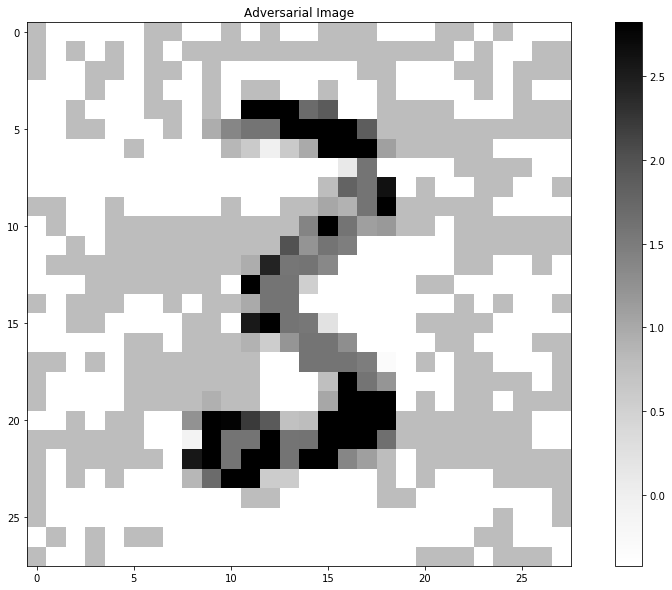

In [32]:
# adversarial image
plt.imshow(cur_adv_images[eps][img], vmin=min_pix, vmax=max_pix, cmap='Greys')
plt.colorbar()
plt.title('Adversarial Image')
plt.show()

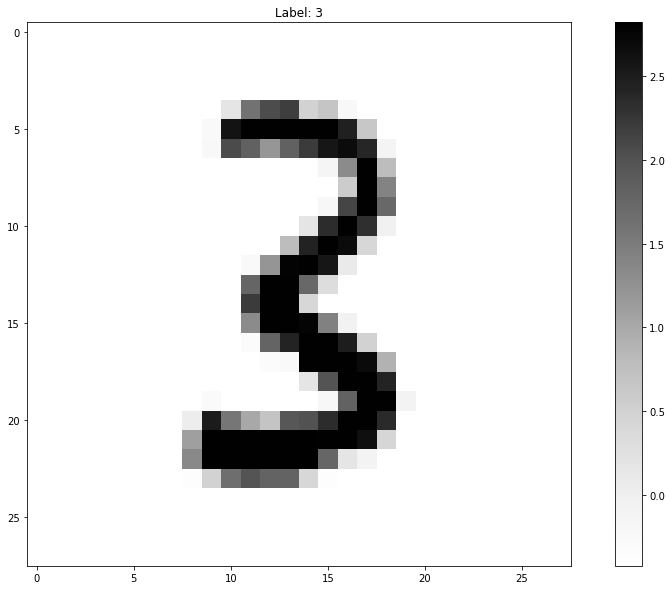

In [33]:
# original non-adversarial image and label
plt.imshow(mnist_val_loader.dataset[img][0].numpy(), vmin=min_pix, vmax=max_pix, cmap='Greys')
plt.colorbar()
plt.title('Label: {}'.format(mnist_val_loader.dataset[img][1].numpy()))
plt.show()

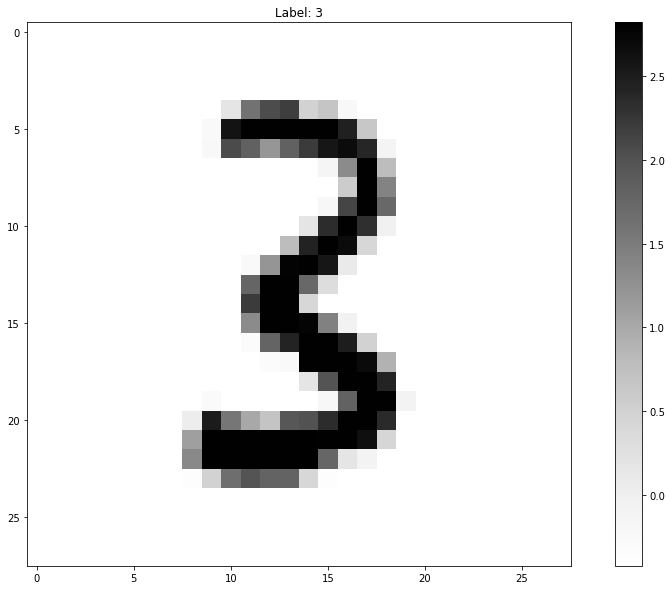

In [34]:
# original non-adversarial image and label
plt.imshow(val_images[img].numpy(), vmin=min_pix, vmax=max_pix, cmap='Greys')
plt.colorbar()
plt.title('Label: {}'.format(val_labels[img].numpy()))
plt.show()

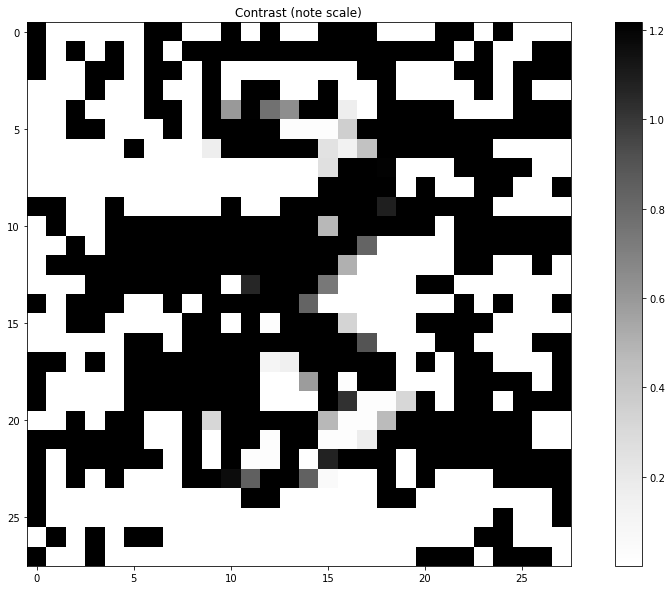

Image distance:
l2 norm: 15.513621
linf norm: 28.470177


In [35]:
# plot contrast
plt.imshow(abs(mnist_val_loader.dataset[img][0].numpy()-cur_adv_images[eps][img]), 
           cmap='Greys')
plt.colorbar()
plt.title('Contrast (note scale)')
plt.show()
print('Image distance:')
print('l2 norm:', np.linalg.norm(mnist_val_loader.dataset[img][0].numpy()-cur_adv_images[eps][img], ord=2))
print('linf norm:', np.linalg.norm(mnist_val_loader.dataset[img][0].numpy()-cur_adv_images[eps][img], ord=np.inf))

In [36]:
# bayesian net prediction

In [37]:
# Prediction when network can decide not to predict
print('Prediction when network can refuse')
total, correct, predicted_for, pred_max_values = test_batch(torch.tensor(cur_adv_images[eps]),
                                                            val_labels, 
                                                            num_samples=100,
                                                            plot=False)

        
print("Total images: ", total)
print("Skipped: ", total-predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / predicted_for))

Prediction when network can refuse
Summary
Total images:  10000
Predicted for:  9900
Accuracy when predicted:  0.25333333333333335
Total images:  10000
Skipped:  100
Accuracy when made predictions: 25 %


In [38]:
from scipy import stats

In [39]:
print(stats.describe(pred_max_values))
print("percentage of confident predictions (>=0.5):",float(len([x for x in pred_max_values if x>=0.5])/float(len(pred_max_values))))

DescribeResult(nobs=10000, minmax=(0.11611809954047203, 1.0), mean=0.7901308575306087, variance=0.056438596437688164, skewness=-0.9280637679485246, kurtosis=-0.41136986684741794)
percentage of confident predictions (>=0.5): 0.837


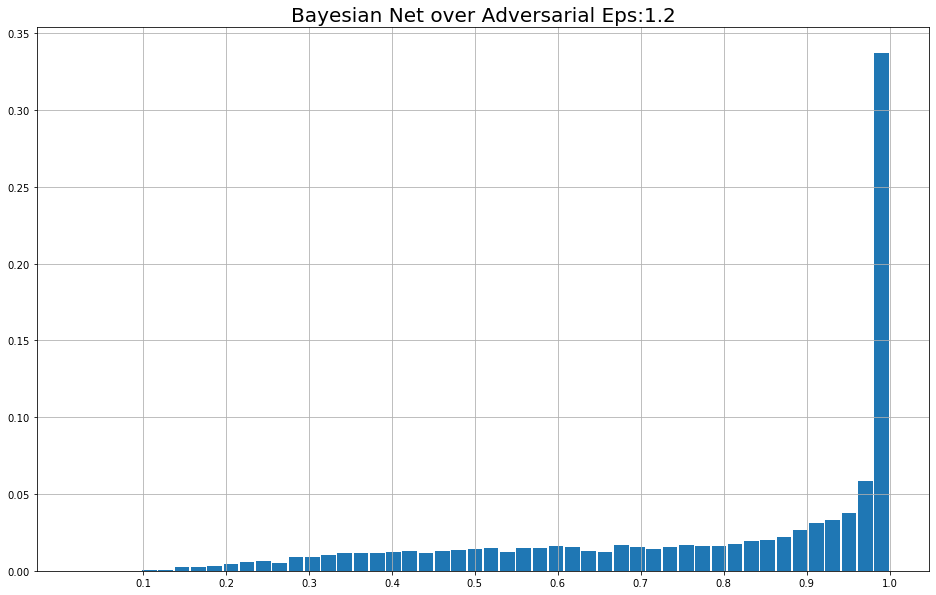

In [40]:
# histogram
weights = np.ones_like(pred_max_values)/len(pred_max_values)
plt.hist(pred_max_values, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.title('Bayesian Net over Adversarial Eps:{:.2}'.format(epsilons[eps]), fontsize=20)
plt.show()

In [41]:
### prepare the plot
# for each model
# for each epsilon
# successful attack count
# + histogram?

In [42]:
# check underlying net accuracy

In [43]:
from foolbox import PyTorchModel, accuracy

In [44]:
val_images, val_labels = mnist_val_loader.dataset.tensors
val_images = val_images.to(device)
val_labels = val_labels.to(device)

bounds = (min_pix+1e-6, max_pix-1e-6)
net.eval()
net_f_model = PyTorchModel(net, bounds=bounds, device=device)

In [45]:
print(accuracy(net_f_model, val_images, val_labels))

0.9739000201225281


In [46]:
### proper comparison only when label changes

with torch.no_grad():
    net.eval()
    ### Underlying network predictions (the ones that was used to create the adverarial images)
    # predictions over the original val images
    classic_original_preds = net(val_images)
    # convert to softmax
    classic_original_preds_softmax = F.softmax(classic_original_preds, dim=-1)
    # maximum (confidence) and argmax label
    classic_original_preds_confidence, classic_original_preds_labels = torch.max(classic_original_preds_softmax, dim=-1)
    classic_original_preds_labels = classic_original_preds_labels.numpy()
    classic_original_preds_confidence = classic_original_preds_confidence.numpy()

In [47]:
# verify raw accuracy
sum(classic_original_preds_labels==val_labels.numpy())/len(val_labels)

0.9739

In [48]:
# verify when confidence over 0.5
confidently_right = 0
confidently_wrong = 0
for i in range(len(val_labels)):
    if classic_original_preds_confidence[i] >=0.5:
        if val_labels[i]==classic_original_preds_labels[i]:
            confidently_right+=1
        else:
            confidently_wrong+=1
print('confidently right, confidently wrong, low confidence')
print(confidently_right, confidently_wrong, len(val_labels)-confidently_right-confidently_wrong)

confidently right, confidently wrong, low confidence
9723 238 39


In [49]:
eps = 1
with torch.no_grad():
    net.eval()
    # predictions over adv images
    classic_adv_preds = net(torch.tensor(cur_adv_images[eps]))
    # convert to softmax
    classic_adv_preds_softmax = F.softmax(classic_adv_preds, dim=-1)
    # maximum (confidence) and argmax label
    classic_adv_preds_confidence, classic_adv_preds_labels = torch.max(classic_adv_preds_softmax, dim=-1)
    classic_adv_preds_labels = classic_adv_preds_labels.numpy()
    classic_adv_preds_confidence = classic_adv_preds_confidence.numpy()

In [50]:
# verify raw accuracy
sum(classic_adv_preds_labels==val_labels.numpy())/len(val_labels)

0.1837

In [51]:
# verify when confidence over 0.5
confidently_right = 0
confidently_wrong = 0
originaly_wrong = 0
low_confidence = 0
for i in range(len(val_labels)):
    # only look at cases where original model was correct
    if val_labels[i] == classic_original_preds_labels[i]:
        if classic_adv_preds_confidence[i] >=0.5:
            if val_labels[i]==classic_adv_preds_labels[i]:
                confidently_right+=1
            else:
                confidently_wrong+=1
        else:
            low_confidence+=1
    else:
        originaly_wrong+=1

print('confidently right:', confidently_right)
print('confidently wrong:', confidently_wrong)
print('originaly wrong:', originaly_wrong)
print('low confidence:', low_confidence)
print(confidently_right+confidently_wrong+originaly_wrong+low_confidence)

confidently right: 1691
confidently wrong: 7249
originaly wrong: 261
low confidence: 799
10000


In [52]:
# Bayesian network predictions
with torch.no_grad():
    net.train()
    # predictions over the original val images
    bayesian_original_preds = give_softmaxes(val_images, num_samples=100)
    # get the means of each sample
    bayesian_original_preds_means = np.mean(bayesian_original_preds, axis=0)
    # maximum (confidence) and argmax label
    bayesian_original_preds_labels = np.argmax(bayesian_original_preds_means, axis=-1)
    bayesian_original_preds_confidence = np.max(bayesian_original_preds_means, axis=-1)

/home/felix/.local/lib/python3.6/site-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


In [53]:
# check that bayesian preds are identical to classic preds
sum(bayesian_original_preds_labels==classic_original_preds_labels)

9795

In [54]:
# verify raw accuracy
sum(bayesian_original_preds_labels==val_labels.numpy())/len(val_labels)

0.9785

In [55]:
# Bayesian network predictions
eps=1
with torch.no_grad():
    net.train()
    # predictions over the adversarial val images
    bayesian_adv_preds = give_softmaxes(torch.tensor(cur_adv_images[eps]), num_samples=100)
    # get the means of each sample
    bayesian_adv_preds_means = np.mean(bayesian_adv_preds, axis=0)
    # maximum (confidence) and argmax label
    bayesian_adv_preds_labels = np.argmax(bayesian_adv_preds_means, axis=-1)
    bayesian_adv_preds_confidence = np.max(bayesian_adv_preds_means, axis=-1)

In [56]:
# verify when confidence over 0.5
confidently_right = 0
confidently_wrong = 0
originaly_wrong = 0
low_confidence = 0
for i in range(len(val_labels)):
    # only look at cases where original model was correct
    if val_labels[i] == bayesian_original_preds_labels[i]:
        if bayesian_adv_preds_confidence[i] >=0.5:
            if val_labels[i]==bayesian_adv_preds_labels[i]:
                confidently_right+=1
            else:
                confidently_wrong+=1
        else:
            low_confidence+=1
    else:
        originaly_wrong+=1

print('confidently right:', confidently_right)
print('confidently wrong:', confidently_wrong)
print('originaly wrong:', originaly_wrong)
print('low confidence:', low_confidence)
print(confidently_right+confidently_wrong+originaly_wrong+low_confidence)

confidently right: 9731
confidently wrong: 4
originaly wrong: 215
low confidence: 50
10000


In [57]:
conf_wrong_classic = []
conf_wrong_bayesian = []
classic_adv_preds_confidence_per_eps = []
bayesian_adv_preds_confidence_per_eps = []

for eps_ind, epsilon in enumerate(epsilons):
    
    # classic
    with torch.no_grad():     
        net.eval()
        # predictions over adv images
        classic_adv_preds = net(torch.tensor(cur_adv_images[eps_ind]))
        # convert to softmax
        classic_adv_preds_softmax = F.softmax(classic_adv_preds, dim=-1)
        # maximum (confidence) and argmax label
        classic_adv_preds_confidence, classic_adv_preds_labels = torch.max(classic_adv_preds_softmax, dim=-1)
        classic_adv_preds_labels = classic_adv_preds_labels.numpy()
        classic_adv_preds_confidence = classic_adv_preds_confidence.numpy()
        
    classic_adv_preds_confidence_per_eps.append(classic_adv_preds_confidence)
    confidently_right = 0
    confidently_wrong = 0
    originaly_wrong = 0
    low_confidence = 0
    for i in range(len(val_labels)):
        # only look at cases where original model was correct
        if val_labels[i] == classic_original_preds_labels[i]:
            if classic_adv_preds_confidence[i] >=0.5:
                if val_labels[i]==classic_adv_preds_labels[i]:
                    confidently_right+=1
                else:
                    confidently_wrong+=1
            else:
                low_confidence+=1
        else:
            originaly_wrong+=1
            
    print('CLASSIC with epsilon #{}={}'.format(eps_ind, epsilon))
    print('confidently right:', confidently_right)
    print('confidently wrong:', confidently_wrong)
    print('originaly wrong:', originaly_wrong)
    print('low confidence:', low_confidence)
    print(confidently_right+confidently_wrong+originaly_wrong+low_confidence)
    
    conf_wrong_classic.append(confidently_wrong)

    with torch.no_grad():     
        net.train()
        # predictions over the adversarial val images
        bayesian_adv_preds = give_softmaxes(torch.tensor(cur_adv_images[eps_ind]), num_samples=100)
        # get the means of each sample
        bayesian_adv_preds_means = np.mean(bayesian_adv_preds, axis=0)
        # maximum (confidence) and argmax label
        bayesian_adv_preds_labels = np.argmax(bayesian_adv_preds_means, axis=-1)
        bayesian_adv_preds_confidence = np.max(bayesian_adv_preds_means, axis=-1)
    
    bayesian_adv_preds_confidence_per_eps.append(bayesian_adv_preds_confidence)
    confidently_right = 0
    confidently_wrong = 0
    originaly_wrong = 0
    low_confidence = 0
    for i in range(len(val_labels)):
        # only look at cases where original model was correct
        if val_labels[i] == bayesian_original_preds_labels[i]:
            if bayesian_adv_preds_confidence[i] >=0.5:
                if val_labels[i]==bayesian_adv_preds_labels[i]:
                    confidently_right+=1
                else:
                    confidently_wrong+=1
            else:
                low_confidence+=1
        else:
            originaly_wrong+=1
            
    conf_wrong_bayesian.append(confidently_wrong)

    print('BAYESIAN with epsilon #{}={}'.format(eps_ind, epsilon))
    print('confidently right:', confidently_right)
    print('confidently wrong:', confidently_wrong)
    print('originaly wrong:', originaly_wrong)
    print('low confidence:', low_confidence)
    print(confidently_right+confidently_wrong+originaly_wrong+low_confidence)
    print()

CLASSIC with epsilon #0=0.0
confidently right: 9710
confidently wrong: 6
originaly wrong: 261
low confidence: 23
10000
BAYESIAN with epsilon #0=0.0
confidently right: 9745
confidently wrong: 2
originaly wrong: 215
low confidence: 38
10000

CLASSIC with epsilon #1=0.012678514351136982
confidently right: 1691
confidently wrong: 7249
originaly wrong: 261
low confidence: 799
10000
BAYESIAN with epsilon #1=0.012678514351136982
confidently right: 9723
confidently wrong: 7
originaly wrong: 215
low confidence: 55
10000

CLASSIC with epsilon #2=0.019017771526705474
confidently right: 1220
confidently wrong: 7714
originaly wrong: 261
low confidence: 805
10000
BAYESIAN with epsilon #2=0.019017771526705474
confidently right: 9722
confidently wrong: 10
originaly wrong: 215
low confidence: 53
10000

CLASSIC with epsilon #3=0.025357028702273965
confidently right: 1008
confidently wrong: 8021
originaly wrong: 261
low confidence: 710
10000
BAYESIAN with epsilon #3=0.025357028702273965
confidently right

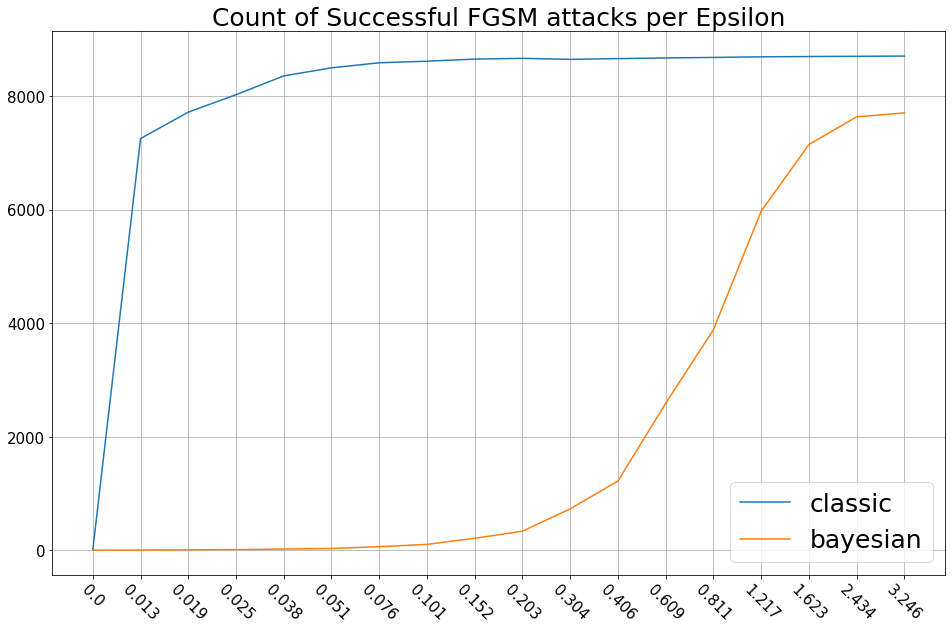

In [58]:
plt.plot(conf_wrong_classic, label='classic')
plt.plot(conf_wrong_bayesian, label='bayesian')


plt.legend(fontsize=25)
plt.grid()
plt.title('Count of Successful FGSM attacks per Epsilon', fontsize=25)
plt.xticks(range(len(epsilons)), labels=np.round(epsilons,3), rotation=-45, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [59]:
epsilons

[0.0,
 0.012678514351136982,
 0.019017771526705474,
 0.025357028702273965,
 0.03803554305341095,
 0.05071405740454793,
 0.0760710861068219,
 0.10142811480909586,
 0.1521421722136438,
 0.20285622961819172,
 0.3042843444272876,
 0.40571245923638344,
 0.6085686888545752,
 0.8114249184727669,
 1.2171373777091503,
 1.6228498369455338,
 2.4342747554183006,
 3.2456996738910675]

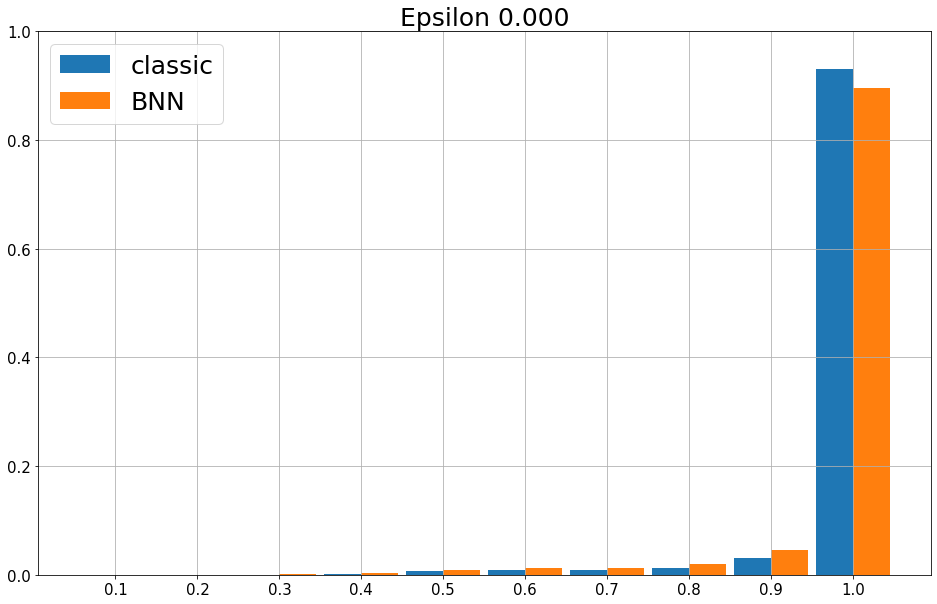

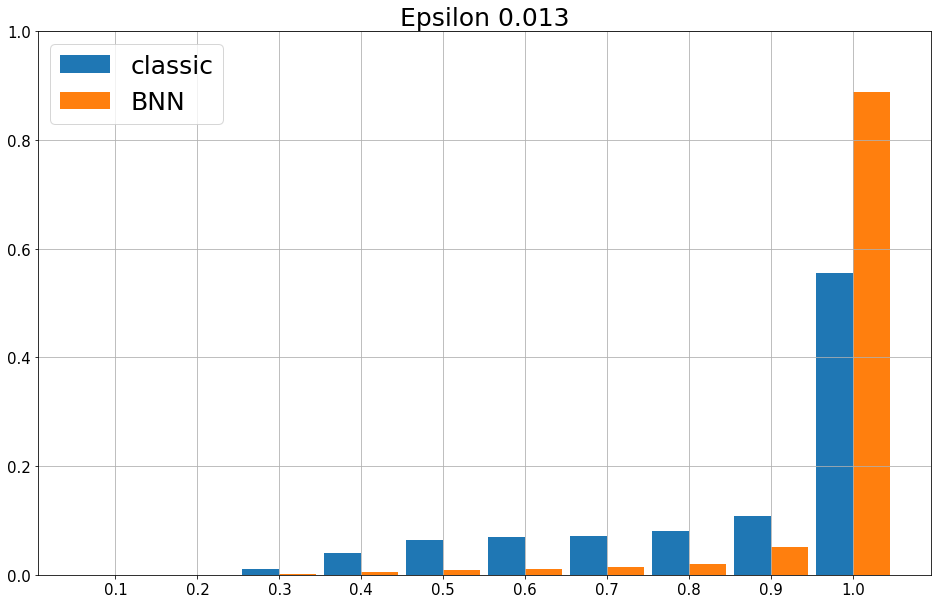

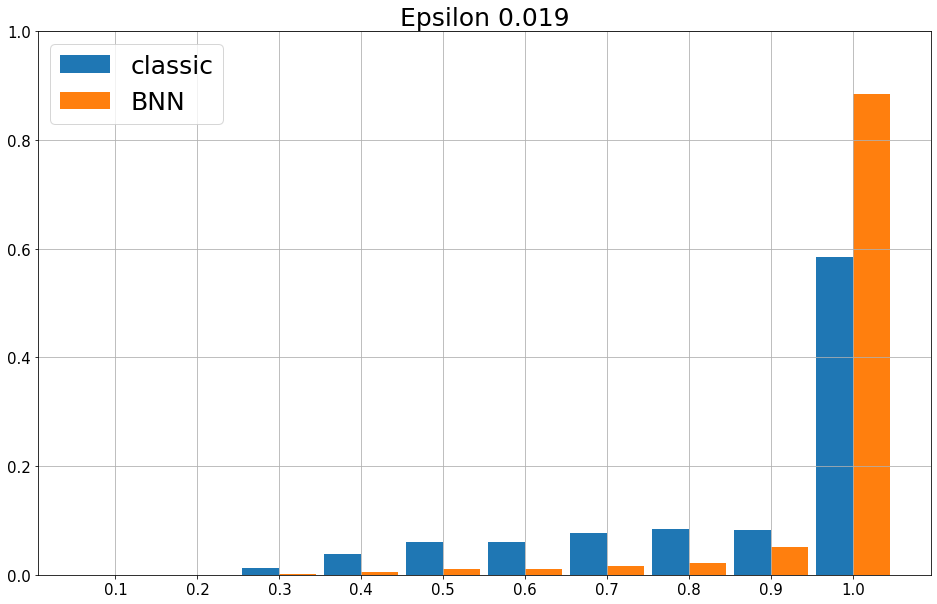

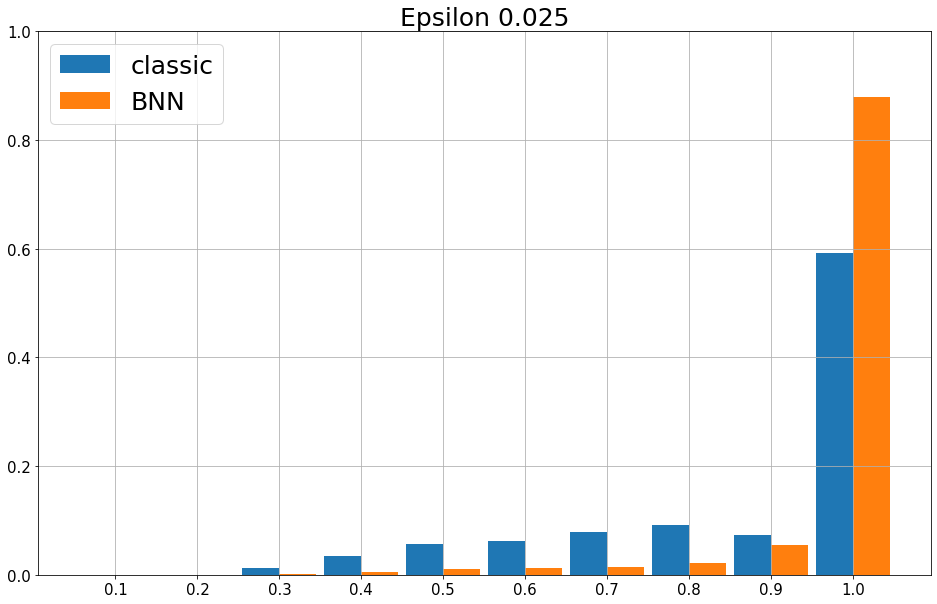

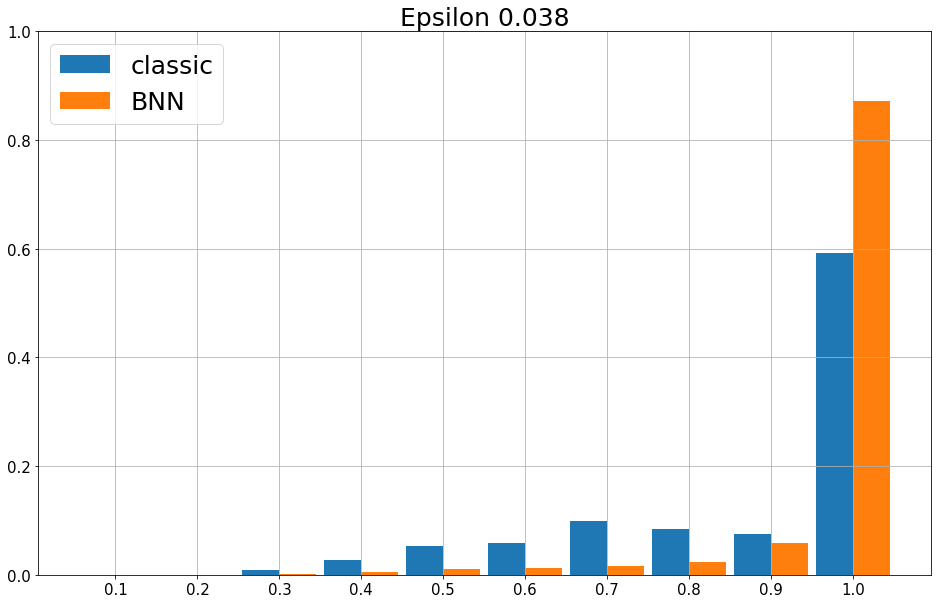

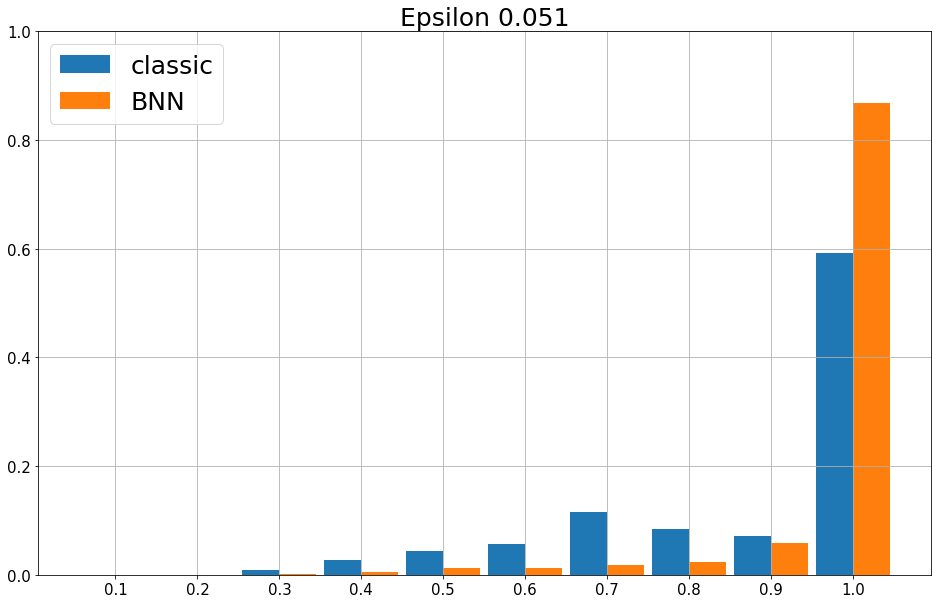

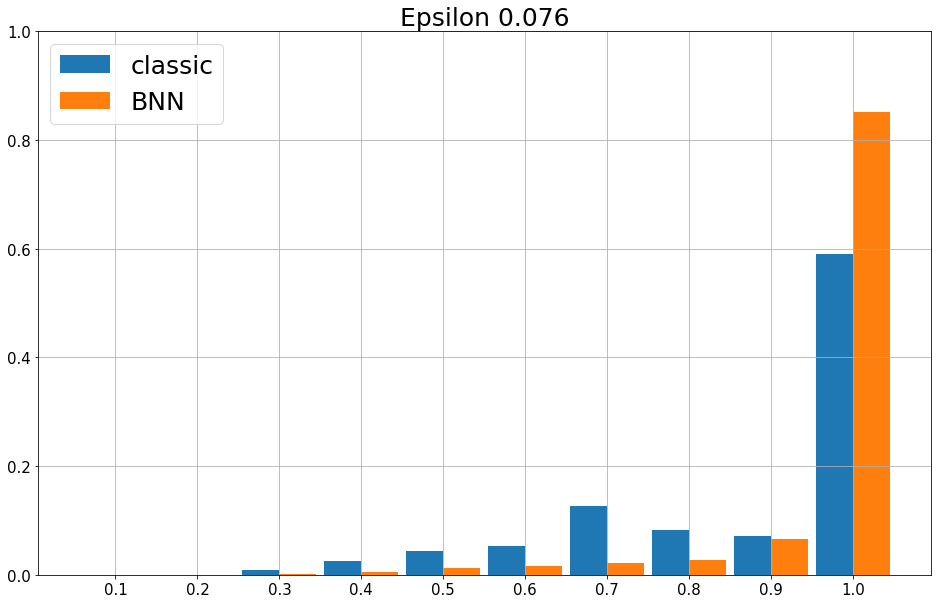

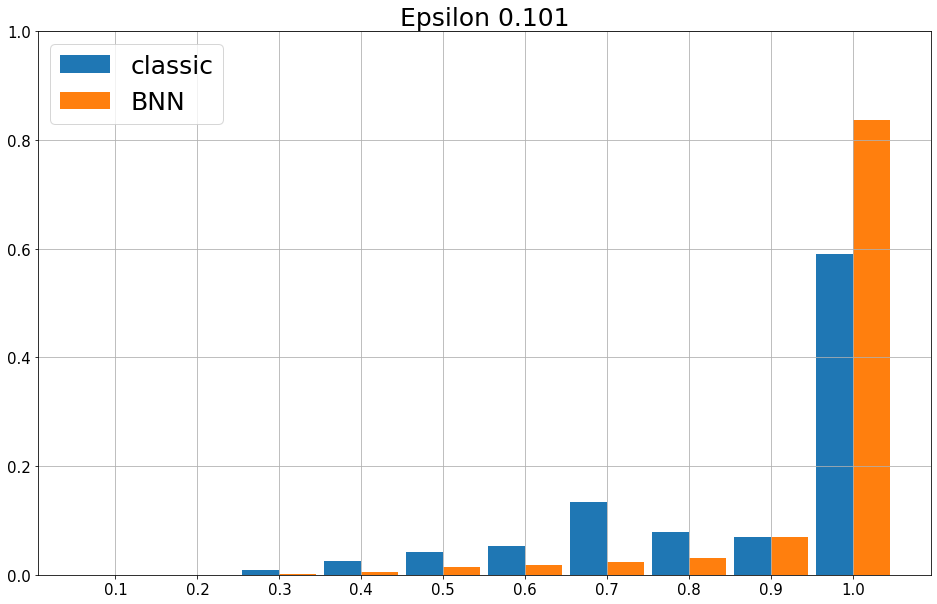

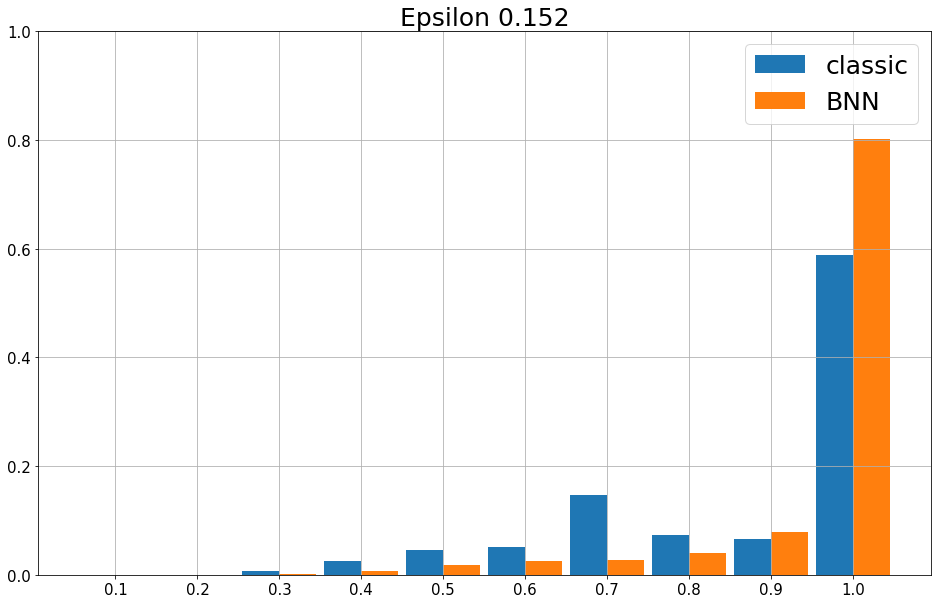

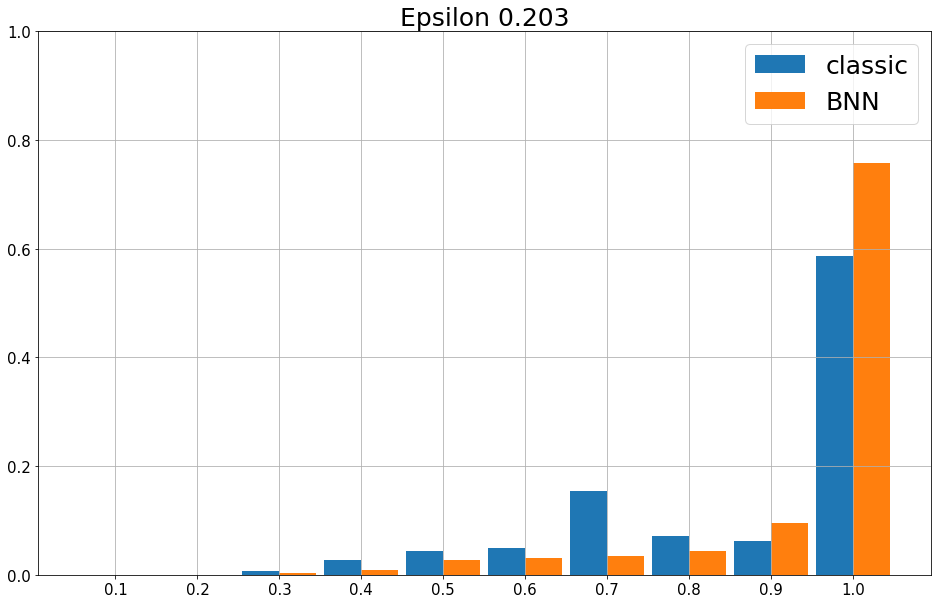

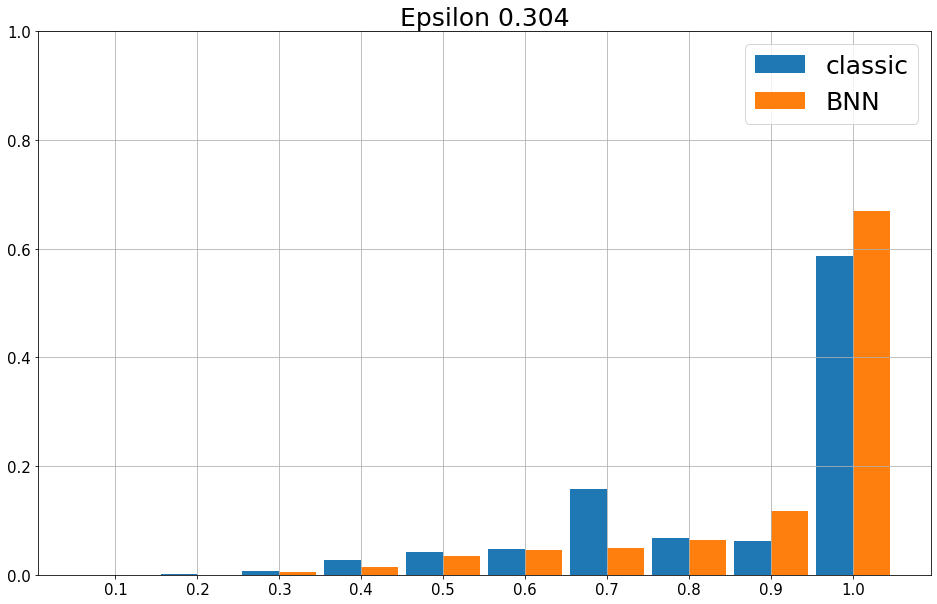

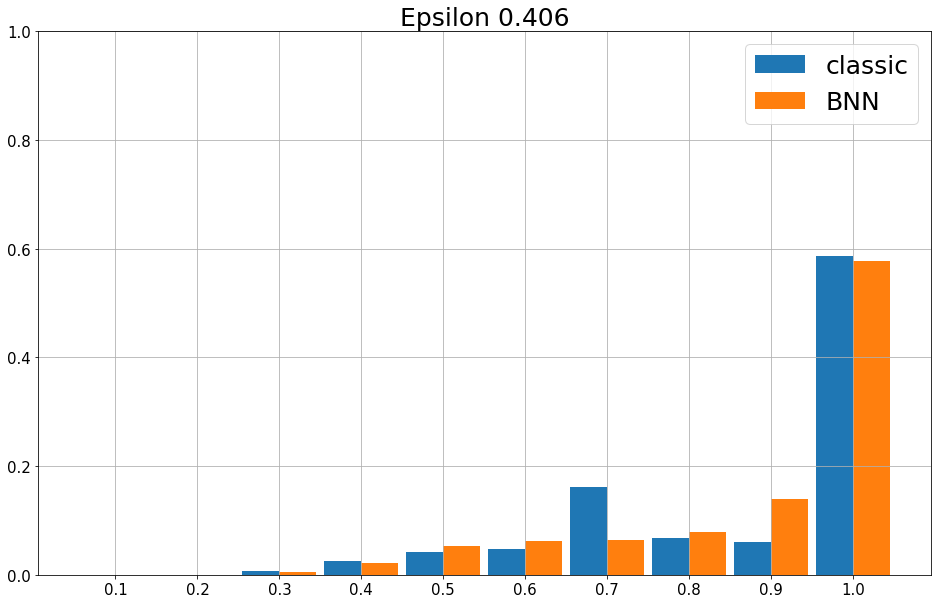

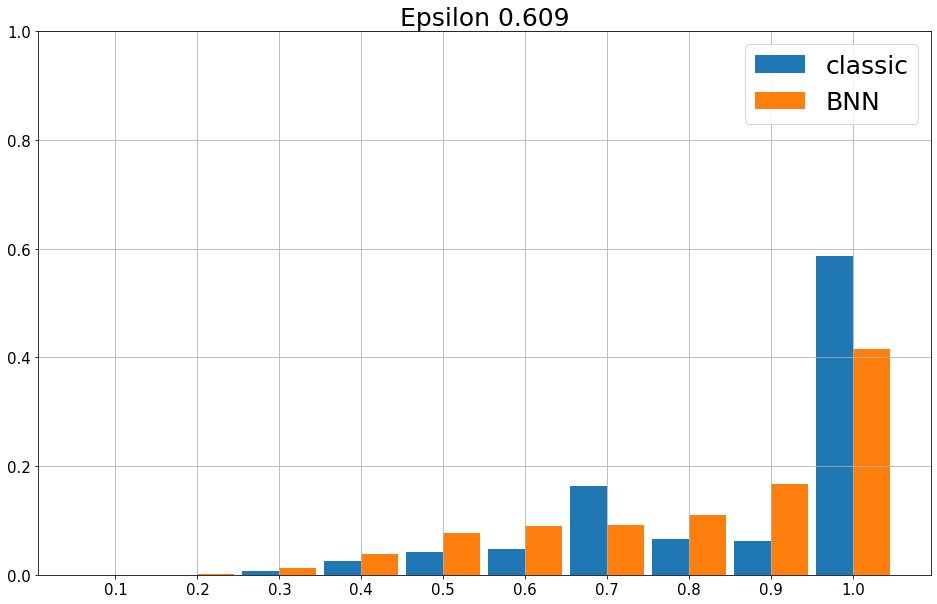

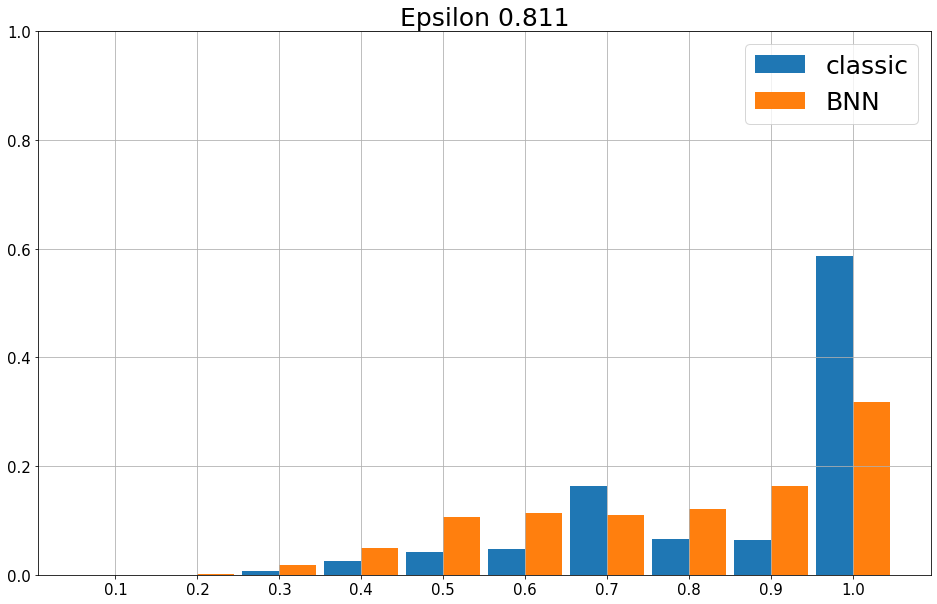

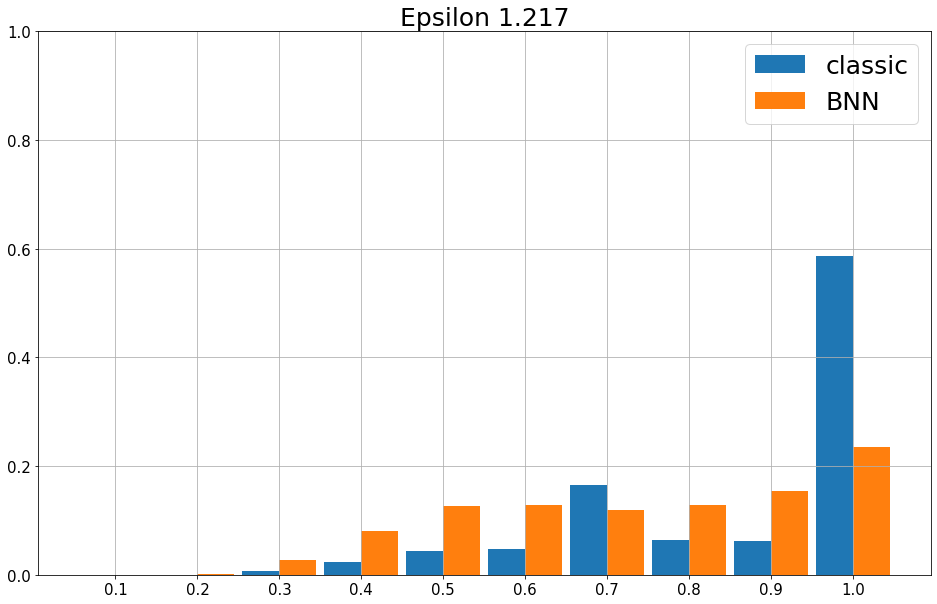

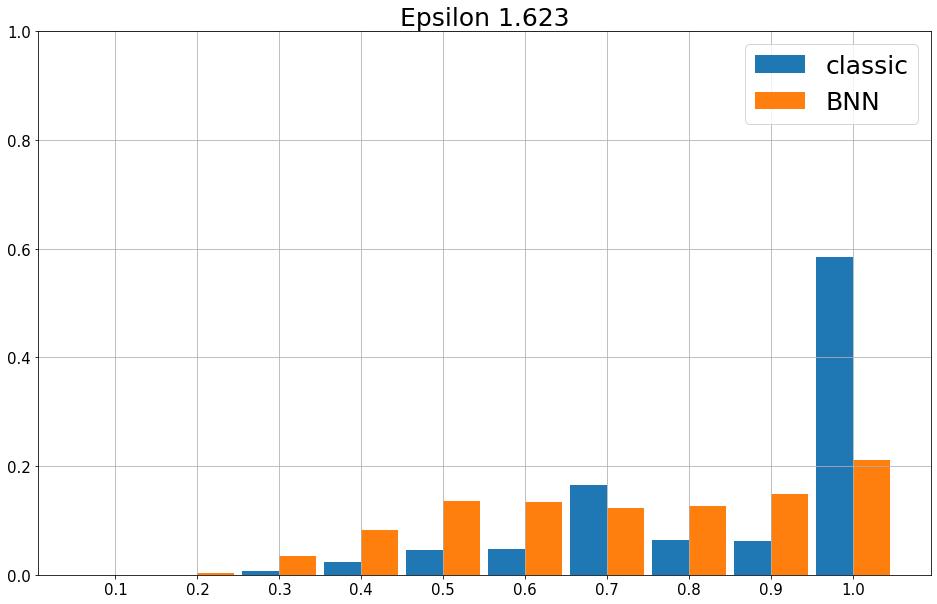

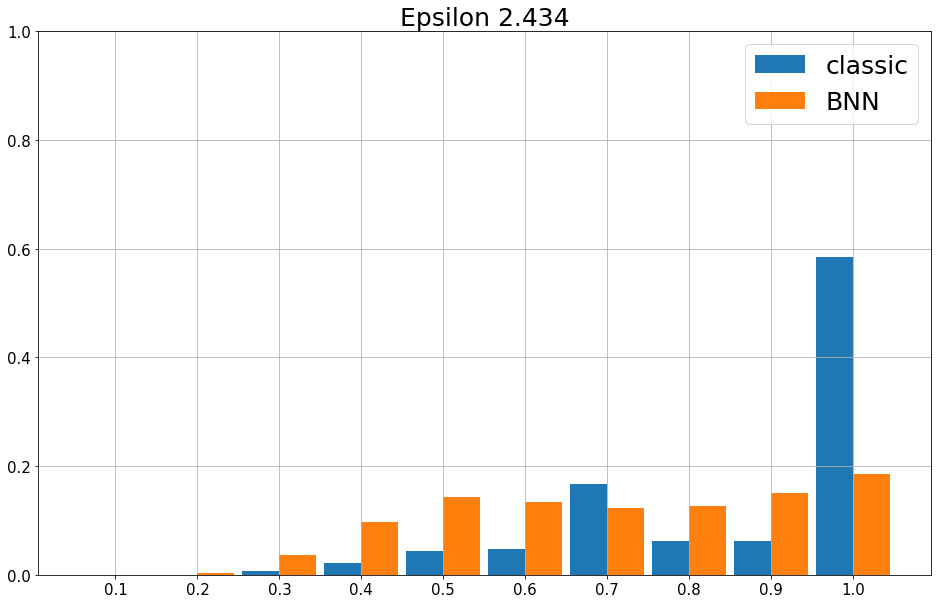

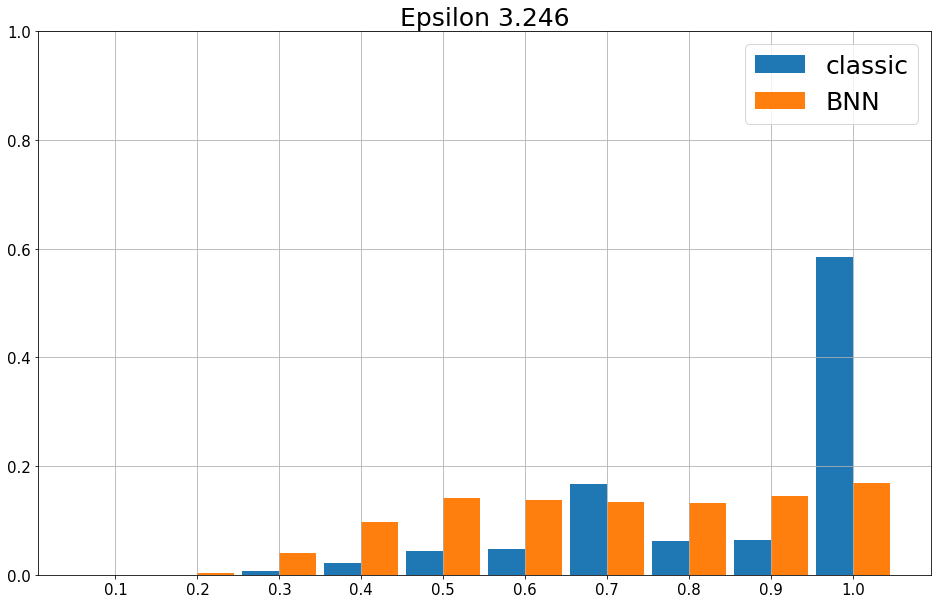

In [60]:
# histogram
for eps_ind,eps in enumerate(epsilons):
    
    weights1 = np.ones_like(classic_adv_preds_confidence_per_eps[eps_ind])/len(classic_adv_preds_confidence_per_eps[eps_ind])
    # plt.hist(classic_adv_preds_confidence_per_eps[eps],
    #          bins= 0.05+ np.arange(11)/10,
    #          rwidth=0.9, align='mid', weights=weights, label='classic')

    weights2 = np.ones_like(bayesian_adv_preds_confidence_per_eps[eps_ind])/len(bayesian_adv_preds_confidence_per_eps[eps_ind])
    # plt.hist(bayesian_adv_preds_confidence_per_eps[eps],
    #          bins= 0.05+ np.arange(11)/10,
    #          rwidth=0.9, align='right', weights=weights, label='bnn')

    plt.hist([classic_adv_preds_confidence_per_eps[eps_ind], bayesian_adv_preds_confidence_per_eps[eps_ind]],
             weights=[weights1,weights2], 
             label=['classic', 'BNN'],
             bins= 0.05+ np.arange(11)/10,
             align='mid',
             rwidth=0.90
            )

    plt.xticks((np.arange(10)+1)/10.0)
    plt.grid(True)
    plt.legend(fontsize=25)
    plt.title('Epsilon {:.3f}'.format(eps), fontsize=25)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylim(top=1.0)

    plt.show()